### Import necessary libraries

In [1]:

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
from PIL import Image
import torchvision.transforms as T

# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###  Data Preparation

In [2]:

train_dir = 'food_datasets/train/'
valid_dir = 'food_datasets/valid/'
test_dir = 'food_datasets/test/'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loading the datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=valid_transforms)

# Creating data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


### Record count

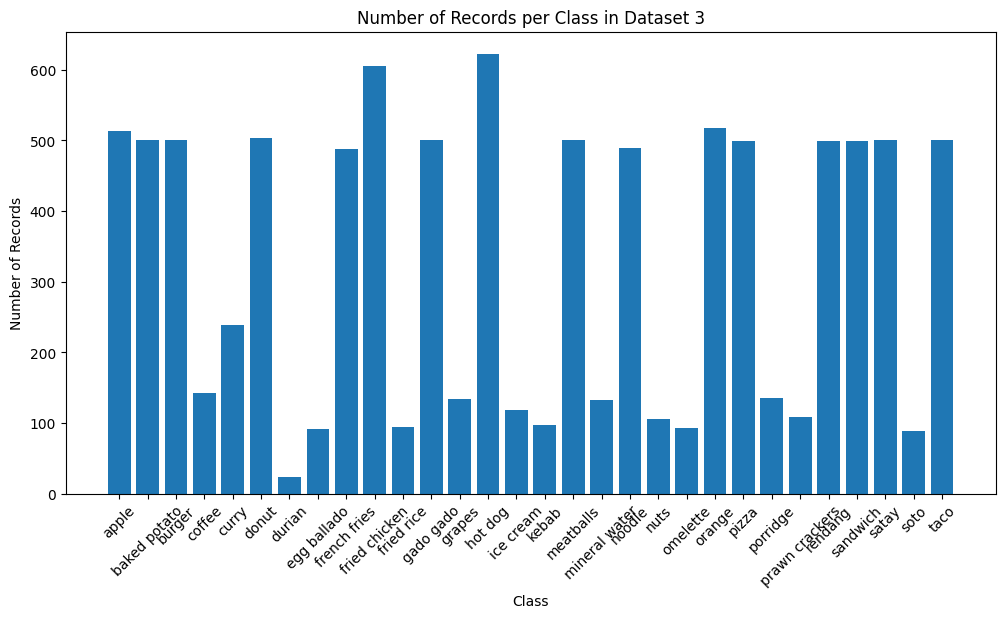

In [3]:
# Counting records for each class in the training set
class_counts = {class_name: 0 for class_name in train_loader.dataset.classes}

# Looping through all samples in the training dataset
for _, label in train_loader.dataset.samples:
    class_name = train_loader.dataset.classes[label]
    class_counts[class_name] += 1

# Plotting the record count per class
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Records')
plt.title('Number of Records per Class in Dataset 3')
plt.xticks(rotation=45)
plt.show()


### Define and Initialize the Model

In [4]:
# Loading pre-trained MobileNetV2 and modify for our classification task
mobilenet_model = models.mobilenet_v2(weights="IMAGENET1K_V1")
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, len(train_data.classes))
mobilenet_model = mobilenet_model.to(device)


### Training the Model with Validation

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(mobilenet_model.parameters(), lr=0.0001)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
epochs = 10

for epoch in range(epochs):
    
    # Training Phase
    mobilenet_model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation Phase
    mobilenet_model.eval()
    val_running_loss = 0.0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet_model(images)
            loss = criterion(outputs, labels)
        
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = val_running_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")

Epoch [1/10], Train Loss: 1.0880, Train Accuracy: 72.55%, Val Loss: 0.5148, Val Accuracy: 86.01%
Epoch [2/10], Train Loss: 0.4065, Train Accuracy: 88.60%, Val Loss: 0.4271, Val Accuracy: 87.22%
Epoch [3/10], Train Loss: 0.2658, Train Accuracy: 92.42%, Val Loss: 0.3599, Val Accuracy: 90.72%
Epoch [4/10], Train Loss: 0.1869, Train Accuracy: 94.89%, Val Loss: 0.3131, Val Accuracy: 91.03%
Epoch [5/10], Train Loss: 0.1377, Train Accuracy: 96.23%, Val Loss: 0.3245, Val Accuracy: 91.03%
Epoch [6/10], Train Loss: 0.1059, Train Accuracy: 97.12%, Val Loss: 0.3781, Val Accuracy: 89.96%
Epoch [7/10], Train Loss: 0.0875, Train Accuracy: 97.64%, Val Loss: 0.3426, Val Accuracy: 90.27%
Epoch [8/10], Train Loss: 0.0644, Train Accuracy: 98.22%, Val Loss: 0.3237, Val Accuracy: 90.87%
Epoch [9/10], Train Loss: 0.0635, Train Accuracy: 98.30%, Val Loss: 0.3328, Val Accuracy: 91.33%
Epoch [10/10], Train Loss: 0.0560, Train Accuracy: 98.42%, Val Loss: 0.4134, Val Accuracy: 89.20%


### Plot Training and Validation Loss

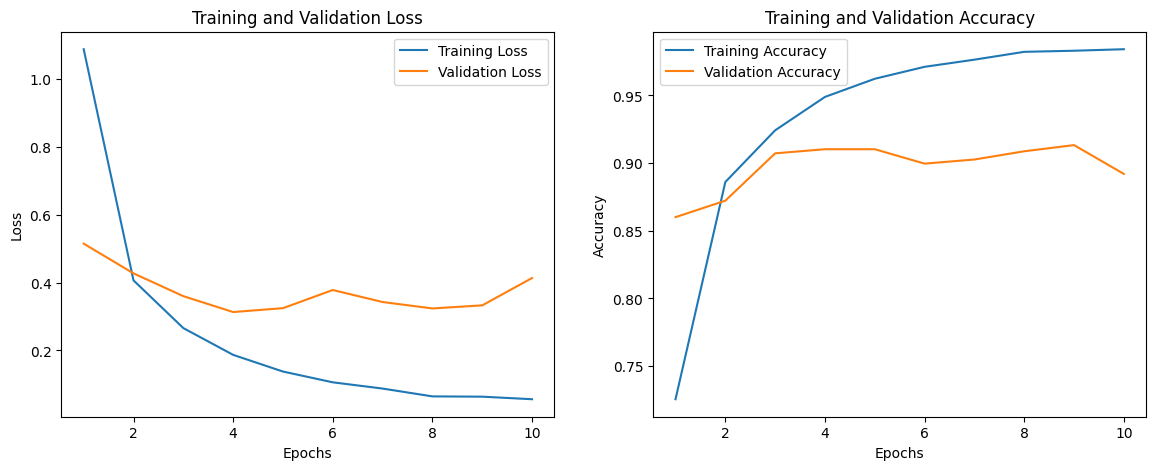

In [6]:
# Plotting Loss and Accuracy Curves
plt.figure(figsize=(14, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


### Evaluate Model on Test Set

In [7]:
# Testing the model and calculating performance metrics
mobilenet_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Test Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1-score: {f1*100:.2f}%")


Test Accuracy: 90.75%, Precision: 91.03%, Recall: 86.85%, F1-score: 88.08%


### Confusion Matrix

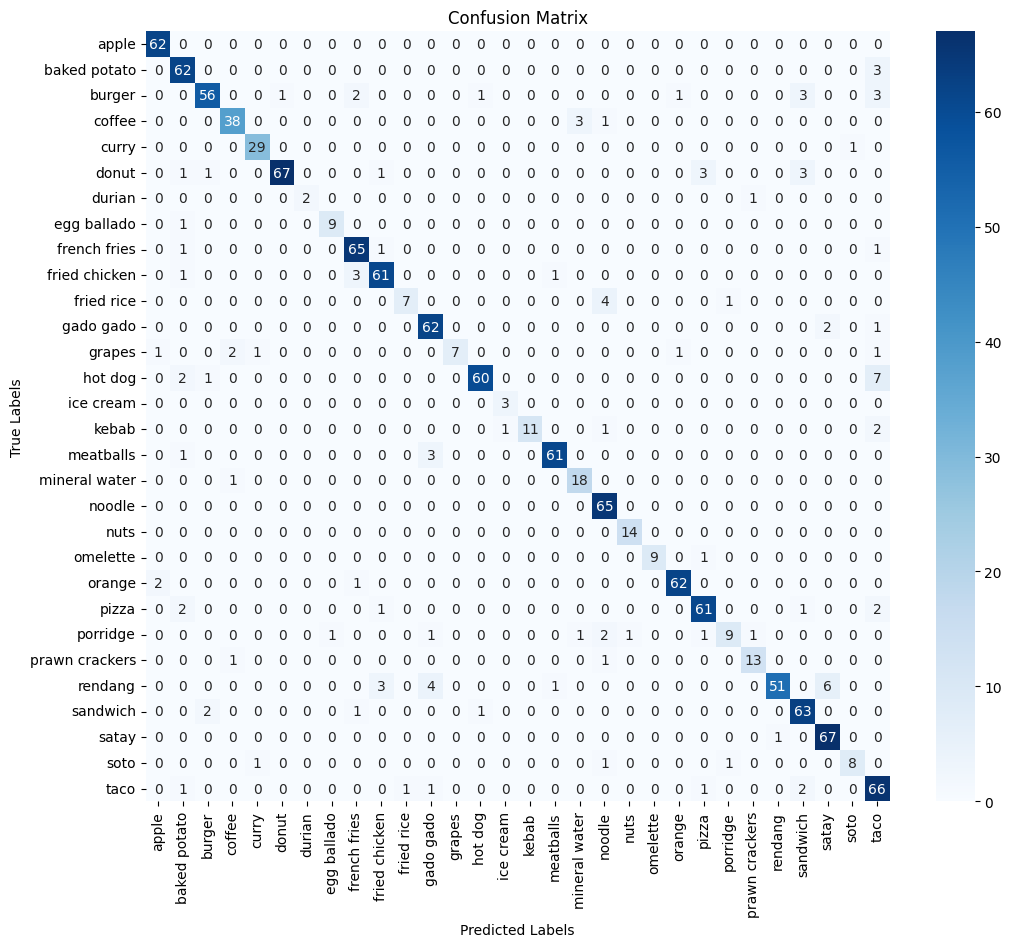

In [8]:

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### t-SNE Visualization

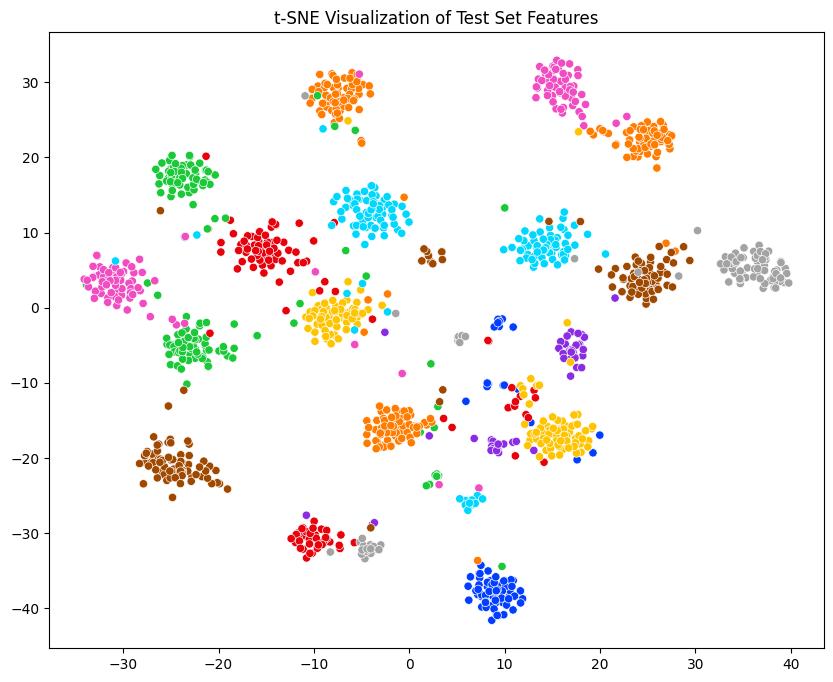

In [10]:
# Initialize lists to store features and labels
features = []
labels = []

# Extract features using the MobileNet model without gradient computation
with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to(device)
        output = mobilenet_model.features(images).view(images.size(0), -1)
        features.extend(output.cpu().numpy())
        labels.extend(lbls.numpy())

# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette="bright", legend=None)
plt.title("t-SNE Visualization of Test Set Features")
plt.show()

### Grad-CAM Implementation

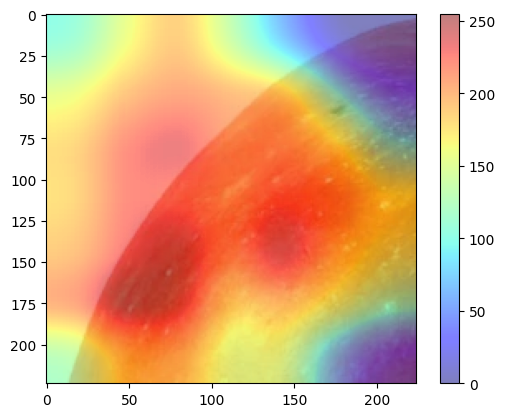

In [16]:

def apply_grad_cam(model, input_image_path, target_layer="features.18"):
    input_image = Image.open(input_image_path).convert("RGB")
    preprocess = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(input_image).unsqueeze(0).to(device)
    
    gradients = []
    activations = None

    def save_activations_and_gradients(module, input, output):
        nonlocal activations
        activations = output
        output.register_hook(lambda grad: gradients.append(grad))

    layer = dict(model.named_modules())[target_layer]
    layer.register_forward_hook(save_activations_and_gradients)

    model.eval()
    outputs = model(input_tensor)
    target_class = outputs.argmax(dim=1).item()
    outputs[0, target_class].backward()

    pooled_grads = torch.mean(gradients[0], dim=[0, 2, 3])
    for i in range(pooled_grads.shape[0]):
        activations[:, i, :, :] *= pooled_grads[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = np.maximum(heatmap.detach().numpy(), 0)
    heatmap /= heatmap.max() if heatmap.max() > 0 else 1
    heatmap = np.array(Image.fromarray(np.uint8(heatmap * 255)).resize((224, 224)))

    plt.imshow(input_image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.show()

# Path to a sample image for Grad-CAM
sample_image = 'food_datasets/test/apple/image_57.jpg'
apply_grad_cam(mobilenet_model, sample_image)
